In [24]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("API_KEYS.env")
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [4]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [5]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)
# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,SNAP
1,A
2,AA
3,AAAU
4,AACH
5,HCDI
6,ABBV
7,ABEO
8,PSTH.U
9,MMLG


In [9]:
# Set the ticker
ticker = input("Enter the ticker to run the Monte Carlo Simulation")

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-03-20", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for TD
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

Enter the ticker to run the Monte Carlo Simulation TD


TD                                
                            open    high    low   close   volume
2020-03-16 00:00:00-04:00  37.35  41.300  36.00  39.280  2454979
2020-03-17 00:00:00-04:00  39.68  41.940  39.04  40.550  2543826
2020-03-18 00:00:00-04:00  38.38  39.170  35.69  37.940  2179993
2020-03-19 00:00:00-04:00  37.04  37.882  35.59  37.430  2361361
2020-03-20 00:00:00-04:00  38.72  40.230  36.06  36.925  2985350

In [10]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)


# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-03-16,39.280
2020-03-17,40.550
2020-03-18,37.940
2020-03-19,37.430
2020-03-20,36.925


In [12]:
# Use the `pct_change` function to calculate daily returns of BB
daily_returns = df.pct_change()

# Use the `mean` function to calculate the mean of daily returns for BB
avg_daily_return = daily_returns.mean()["close"]

# Use the `std` function to calculate the standard deviation of daily returns for BB
std_dev_daily_return = daily_returns.std()["close"]

In [16]:
# Set number of trading days and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 252 
stock_last_price = df['close'][-1]

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_ticker_prices = [stock_last_price]

        # Simulate the returns for 252  trading days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_ticker_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_ticker_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_ticker_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulated Stock Prices,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,...,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000,36.925000
1,36.273987,37.202743,37.416889,36.928767,36.586958,35.871780,36.915600,36.137616,36.741413,36.632228,...,37.488571,38.059174,36.657232,36.874044,35.901272,36.558737,37.400670,36.748375,36.782473,36.653980
2,36.675833,37.528919,36.167117,37.148037,36.628485,36.610104,36.998521,35.741457,38.091823,36.564887,...,38.436670,37.700402,37.152205,37.375154,35.308863,35.651677,37.176405,36.912728,37.041209,36.036380
3,36.768031,37.813111,36.026392,36.844751,35.362265,35.755050,36.669686,35.478187,38.236206,36.383092,...,37.689195,36.998488,38.668054,37.520356,35.965382,35.424550,36.330568,36.992605,35.978929,36.947597
4,36.573682,37.778733,36.624147,37.453275,36.688179,36.021656,36.903016,35.199533,37.449603,36.746472,...,38.357969,38.004698,38.356513,37.628990,36.600410,36.367547,36.162565,37.343114,36.083896,37.717965


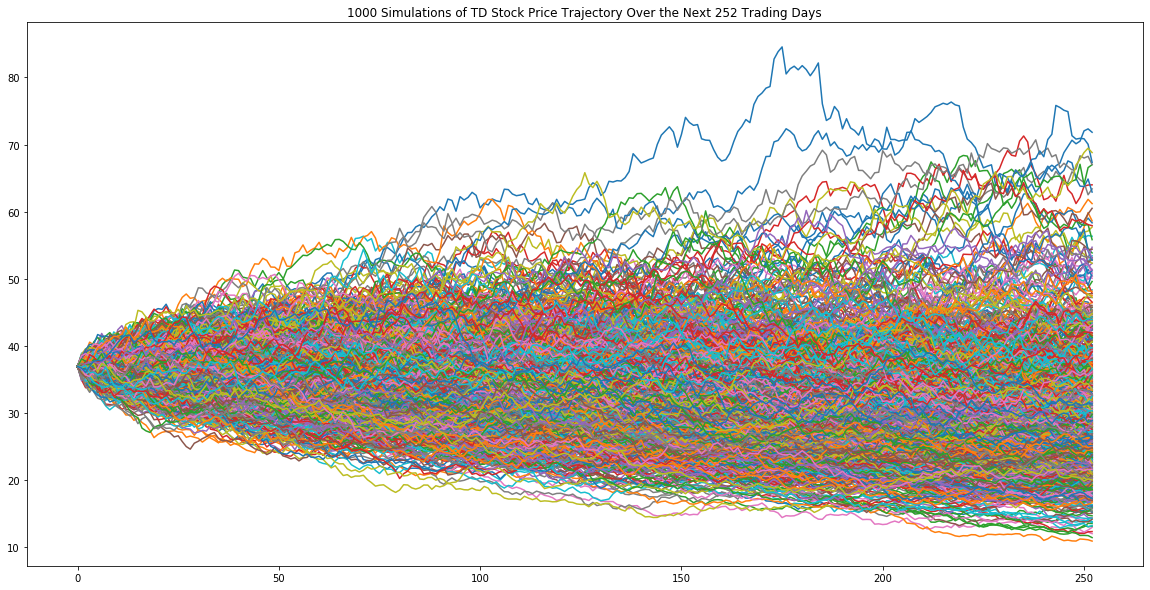

In [18]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a 252 * 3 trading day simulation
plot_title = f"{n+1} Simulations of {ticker} Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title, figsize =[20,10])

In [19]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulated Stock Prices    22.629276
Simulation 1              26.554366
Simulation 2              26.433707
Simulation 3              27.906522
Simulation 4              20.370568
Name: 252, dtype: float64

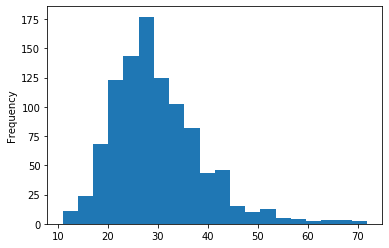

In [20]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

In [21]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(26.133, 29.179]    0.176823
(23.087, 26.133]    0.142857
(29.179, 32.226]    0.124875
(20.04, 23.087]     0.122877
(32.226, 35.272]    0.101898
(35.272, 38.319]    0.081918
(16.994, 20.04]     0.067932
(41.365, 44.411]    0.045954
(38.319, 41.365]    0.042957
(13.948, 16.994]    0.023976
(44.411, 47.458]    0.014985
(50.504, 53.55]     0.012987
(10.839, 13.948]    0.010989
(47.458, 50.504]    0.009990
(53.55, 56.597]     0.004995
(56.597, 59.643]    0.003996
(65.736, 68.782]    0.002997
(62.689, 65.736]    0.002997
(59.643, 62.689]    0.001998
(68.782, 71.828]    0.001998
Name: 252, dtype: float64

In [22]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    16.142727
0.975    52.308527
Name: 252, dtype: float64

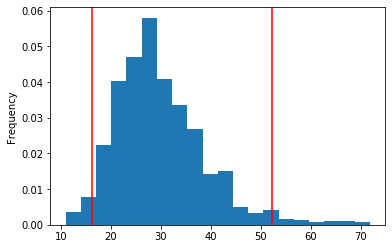

In [25]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')